This notebook is structured as:
- Showing that WLS is not the correct approach even with idealized data

In [5]:
%matplotlib inline 

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from scipy import odr

## Setup

Below is a simulation where we have 
$$\mu_y(e) = \alpha_0 + \alpha_1 \mu_x(e)$$
where $e$ stands for different experiments. Let's pretend we only have $k$ measurement (configurations) per experiment but we have:
where
$$\binom{x_i(e)}{y_i(e)} \sim MVN\left(\binom{\mu_x(e)}{\mu_y(e)}, \underbrace{\begin{bmatrix} \sigma^2_x & 0 \\ 0 & \sigma^2_y \end{bmatrix}}_{=\Sigma}\right)$$

In [7]:
num_e = 20
num_config = 100

In [8]:
e_range = np.linspace(0, 100, num_e)

#### Define the data generation process

First define the truth we want to recover with data

In [9]:
alpha0 = 1
alpha1 = 2
def mu_x(e_i):
    return e_i
def mu_y(mu_x):
    return alpha1 * mu_x + alpha0

In [10]:
mu_xs = [mu_x(e_i) for e_i in e_range]
mu_ys = [mu_y(mu_xi) for mu_xi in mu_xs]

In [11]:
noise_sigma = 10

Our data is generated as a contaminated version of the truth

In [12]:
x = np.stack([np.random.normal(mu_xi, noise_sigma, num_config)
              for mu_xi in mu_xs])
y = np.stack([np.random.normal(mu_yi, noise_sigma, num_config)
              for mu_yi in mu_ys])

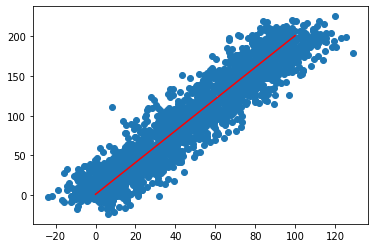

In [13]:
plt.scatter(x.reshape(-1), y.reshape(-1))
plt.plot(mu_xs, mu_ys, color='red')

Define how data is related to the truth, the usual assumption is that data is an unbiased measurement of the truth

#### It's common to use linear regression to estimate the line

In [14]:
num_sim = 1000
coeffs = []
for i in range(num_sim):
    sim_x = np.concatenate(
        [np.random.normal(mu_xi, noise_sigma, num_config)
         for mu_xi in mu_xs])
    sim_y = np.concatenate(
        [np.random.normal(mu_yi, noise_sigma, num_config)
         for mu_yi in mu_ys])
    ols = sm.OLS(sim_y, sm.add_constant(sim_x)).fit()
    coeffs.append(ols.params)

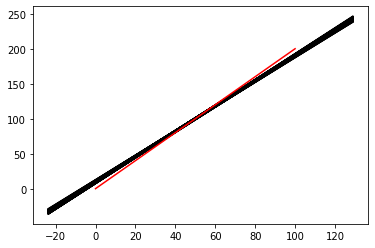

In [15]:
poss_x = np.linspace(np.min(x), np.max(x), 100)
for i in range(num_sim):
    plt.plot(poss_x,
             coeffs[i][0] + coeffs[i][1] * poss_x,
             color='black')
    
plt.plot(mu_xs, mu_ys, color='red')

In [16]:
coeffs_mat = np.stack(coeffs)

In [17]:
np.apply_along_axis(np.mean, 0, coeffs_mat)

array([10.79041508,  1.80407816])

Recall that the true values, we want to estimate are:

In [18]:
np.array([alpha0, alpha1])

array([1, 2])

#### Is it bias or variance?

In [19]:
np.apply_along_axis(np.std, 0, coeffs_mat)

array([0.84195444, 0.01426594])

answer: Definitely bias given the small-ish standard deviatiosn.

#### What to do? Orthogonal Regression

In [20]:
def linear_fun(alpha_hat, x):
    return alpha_hat[0] + alpha_hat[1] * x

lin_mod = odr.Model(linear_fun)

In [21]:
coeffs = []
for i in range(num_sim):
    sim_x = np.stack(
        [np.random.normal(mu_xi, noise_sigma, num_config)
         for mu_xi in mu_xs])
    sim_y = np.stack(
        [np.random.normal(mu_yi, noise_sigma, num_config)
         for mu_yi in mu_ys])
    sx = np.mean(np.apply_along_axis(np.std, 1, sim_x))
    sy = np.mean(np.apply_along_axis(np.std, 1, sim_y))
    sim_x_flat = sim_x.reshape(-1)
    sim_y_flat = sim_y.reshape(-1)
    mydata = odr.RealData(sim_x_flat, sim_y_flat, sx=sx, sy=sy)
    # starting values
    ols = sm.OLS(sim_y_flat,
                 sm.add_constant(sim_x_flat)).fit()
    myodr = odr.ODR(mydata, lin_mod, beta0=ols.params).run()
    coeffs.append(myodr.beta)

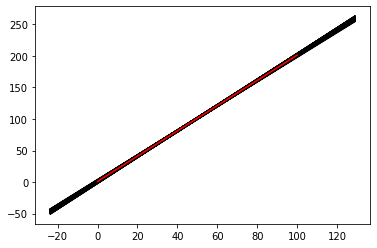

In [22]:
for i in range(num_sim):
    plt.plot(poss_x,
             coeffs[i][0] + coeffs[i][1] * poss_x,
             color='black')
    
plt.plot(mu_xs, mu_ys, color='red')

#### Something closer to the actual data

First, simulate data that looks remotely similar to the output data.
There are 2 relationships that I noticed:
- The linear line you're trying to fit between $X$ and $Y$
- The strongly relationship between hollow dots.

I was told that:
- The monte carlo samples are recycles across experiments

To emulate that pattern, I've setup the simulation as follows:
- $\epsilon \stackrel{i.i.d.}{\sim} N(0, \sigma^2)$
- $X_{(e, i)} = f_x(e) + g_e(\epsilon_i)$
- $Y_{(e, i)} = \beta_0 + \beta_1 * f_x(e) + h_e(\epsilon_i)$

We wish to recover $\beta_0$ and $\beta_1$

We have to assume that
- $E(g_e(\epsilon_i)) = 0$
- $E(h_e(\epsilon_i)) = 0$

In [23]:
num_e = 20
experiments = np.sort(np.random.uniform(-0.005, 0.04, num_e))

In [24]:
betas = [1, 2]

In [25]:
# One set of configurations
num_config = 100
sigma = 0.0005
eps = np.random.normal(0, sigma, num_config)

In [26]:
sigma = 0.0005

def f_x(e):
    return e

def g(e, eps):
    return (1 + e) * eps

def h(e, eps):
    random_effect = np.random.normal(0, 0.01)
    return 1e6 * (0.01 + e) * (eps)**2 * np.sign(eps) + random_effect

x = np.stack([f_x(e_i) + g(e_i, eps) for e_i in experiments])
y = np.stack([betas[0] + f_x(e_i) * betas[1] + h(e_i, eps)
              for e_i in experiments])

In [27]:
x_avg = np.apply_along_axis(np.mean, 1, x)
y_avg = np.apply_along_axis(np.mean, 1, y)

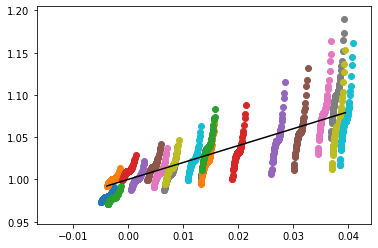

In [33]:
for i in range(len(experiments)):
    plt.scatter(x[i, :], y[i, :])

plt.plot(f_x(experiments), betas[0] + betas[1] * experiments, color="black")

#### Naive Weighted Least Squares Approach

In [34]:
# Bootstrap + WLS
num_sim = 1000
boot_pred = []
for i in range(num_sim):
    # We bootstrap configurations that will apply to each experiment
    boot_ind = np.random.choice(num_config, num_config)
    boot_x = x[:, boot_ind]
    boot_y = y[:, boot_ind]
    boot_sy = np.apply_along_axis(np.std, 1, boot_y)
    boot_x_avg = np.apply_along_axis(np.mean, 1, boot_x)
    boot_y_avg = np.apply_along_axis(np.mean, 1, boot_y)
    boot_wls = sm.WLS(boot_y_avg, sm.add_constant(boot_x_avg),
                     weights=1/boot_sy).fit()
    boot_pred.append(x_avg * boot_wls.params[1] + boot_wls.params[0])

In [35]:
boot_pred_mat = np.stack(boot_pred)
percs = np.apply_along_axis(lambda x: np.percentile(x, [2.5, 97.5]), 0, boot_pred_mat)

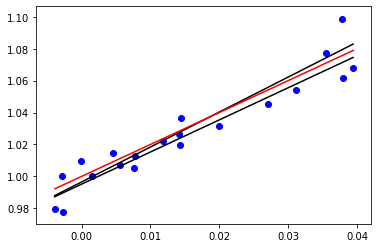

In [36]:
for i in percs:
    plt.plot(x_avg, i, color="black")

plt.plot(f_x(experiments),
         betas[0] + betas[1] * f_x(experiments),
         color="red")
plt.scatter(x_avg, y_avg, color="blue")

- WLS seems to do alright actually...
- Bootstrap definitely is underestimating the uncertainty

Observation: You do not have a cloud of measurement error around each experiment. Instead, you have a clean curve around each experiment. Suggesting that if you knew X, you could infer Y.

This would explain why WLS 

I believe we should try to estimate the relationship for each experiment, this will make the point of averages stay on the curves. 

In [1]:
# If we are willing to use polynomials to fit the relationship
ols_es = []
for i in range(num_e):
    covariates = np.stack([np.power(x[i, :], j) for j in range(4)], axis=-1)
    ols = sm.OLS(y[i, :].reshape(-1, 1), covariates).fit()
    ols_es.append(ols.params)

NameError: name 'num_e' is not defined

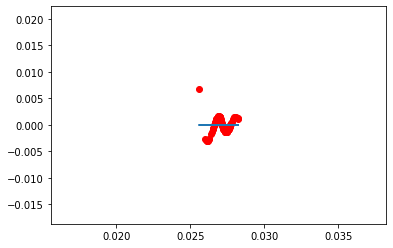

In [495]:
i = 5
covariates = np.stack([np.power(x[i, :], j) for j in range(4)], axis=-1)
plt.scatter(y[i, :], np.matmul(covariates, ols_es[i]), color="red")
plt.plot(y[i, :], y[i, :], color="black")

Then use the fitted values to fit ODR, the error here is assumed to come from "model misspecification" from using a line specifically.

In [3]:
x_avg = np.apply_along_axis(np.mean, 1, x)

NameError: name 'np' is not defined

In [ ]:
y_avg = []
for i in range(num_e):
    covariates = np.stack([np.power(x_avg[i], j) for j in range(4)], axis=-1)
    y_avg.append(np.sum(covariates * ols_es[i]))

In [ ]:
mydata = odr.Data(x_avg, y_avg)
# starting values
ols = sm.OLS(y_avg,
             sm.add_constant(x_avg)).fit()
myodr = odr.ODR(mydata, lin_mod, beta0=ols.params).run()

In [ ]:
myodr.beta

### Similarly, use bootstrap to get uncertainties

In [ ]:
# Bootstrap + ODR
num_sim = 1000
odd_boot_pred = []
for i in range(num_sim):
    boot_ind = np.random.choice(num_config, num_config)
    boot_x = x[:, boot_ind]
    boot_y = y[:, boot_ind]
    boot_x_avg = np.apply_along_axis(np.mean, 1, boot_x)
    boot_y_avg = []
    for i in range(num_e):
        covariates = np.stack([np.power(boot_x_avg[i], j)
                               for j in range(4)], axis=-1)
        # ols_es are NOT re-estimated via bootstrap!
        boot_y_avg.append(np.sum(covariates * ols_es[i]))
    boot_data = odr.Data(boot_x_avg, boot_y_avg)
    # starting values
    boot_ols = sm.OLS(boot_y_avg,
                      sm.add_constant(boot_x_avg)).fit()
    boot_odr = odr.ODR(boot_data, lin_mod, beta0=boot_ols.params).run()
    # There seems to be a bug where the cov_beta is not scaled properly
    scaling = boot_odr.sd_beta[0]**2 / boot_odr.cov_beta[0, 0]
    L = np.linalg.cholesky(boot_odr.cov_beta * scaling)
    # Drawing here is to artificially add in the uncertainty due to the random effects
    boot_beta_samp = boot_odr.beta + np.matmul(L, np.random.normal(0, 1, 2))
    odd_boot_pred.append(x_avg * boot_beta_samp[1] + boot_beta_samp[0])

In [ ]:
odd_boot_pred_mat = np.stack(odd_boot_pred)
odd_percs = np.apply_along_axis(lambda x: np.percentile(x, [2.5, 97.5]),
                            0,
                            odd_boot_pred_mat)

In [ ]:
for i in odd_percs:
    plt.plot(x_avg, i, color="black")

plt.plot(f_x(experiments),
         alphas[0] + alphas[1] * f_x(experiments),
         color="red")
plt.scatter(x_avg, y_avg, color="blue")